# Assignment 6: Neural Network Showdown

Build and compare neural network architectures on image and time-series data.

## Setup

In [1]:
%pip install -q -r requirements.txt

# GPU acceleration (platform-specific)
import platform
if platform.system() == "Darwin" and platform.machine() == "arm64":
    %pip install -q tensorflow-metal

%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

# Report available accelerators
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU acceleration: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  {gpu.name}")
else:
    print("No GPU detected — using CPU")

from tensorflow import keras
from keras import Sequential
from keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Input
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from helpers import (
    load_cifar10, load_ecg5000,
    plot_training_history, plot_confusion_matrix,
    plot_sample_images, plot_ecg_traces, plot_predictions,
    CIFAR10_CLASSES, ECG_CLASSES,
)

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

No GPU detected — using CPU
Setup complete!


---

## Part 1: Dense Baseline on CIFAR-10

**Task:** Build a Dense (fully connected) network to classify CIFAR-10 images.

CIFAR-10 has 60,000 color images (32x32x3) across 10 classes. A Dense network
flattens each image into 3,072 numbers and classifies from there. This is our
baseline — it ignores spatial structure entirely.

**Architecture requirements:**
- Flatten the input
- At least 2 hidden Dense layers with ReLU activation
- Dropout after each hidden layer
- Output: Dense(10, softmax)

In [3]:
print("Part 1: Dense Baseline on CIFAR-10")
print("-" * 40)

# Load data (normalized to [0,1], one-hot encoded)
X_train, y_train, X_test, y_test = load_cifar10()
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Part 1: Dense Baseline on CIFAR-10
----------------------------------------
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/workspaces/06-brainiac-oscar-peng/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)


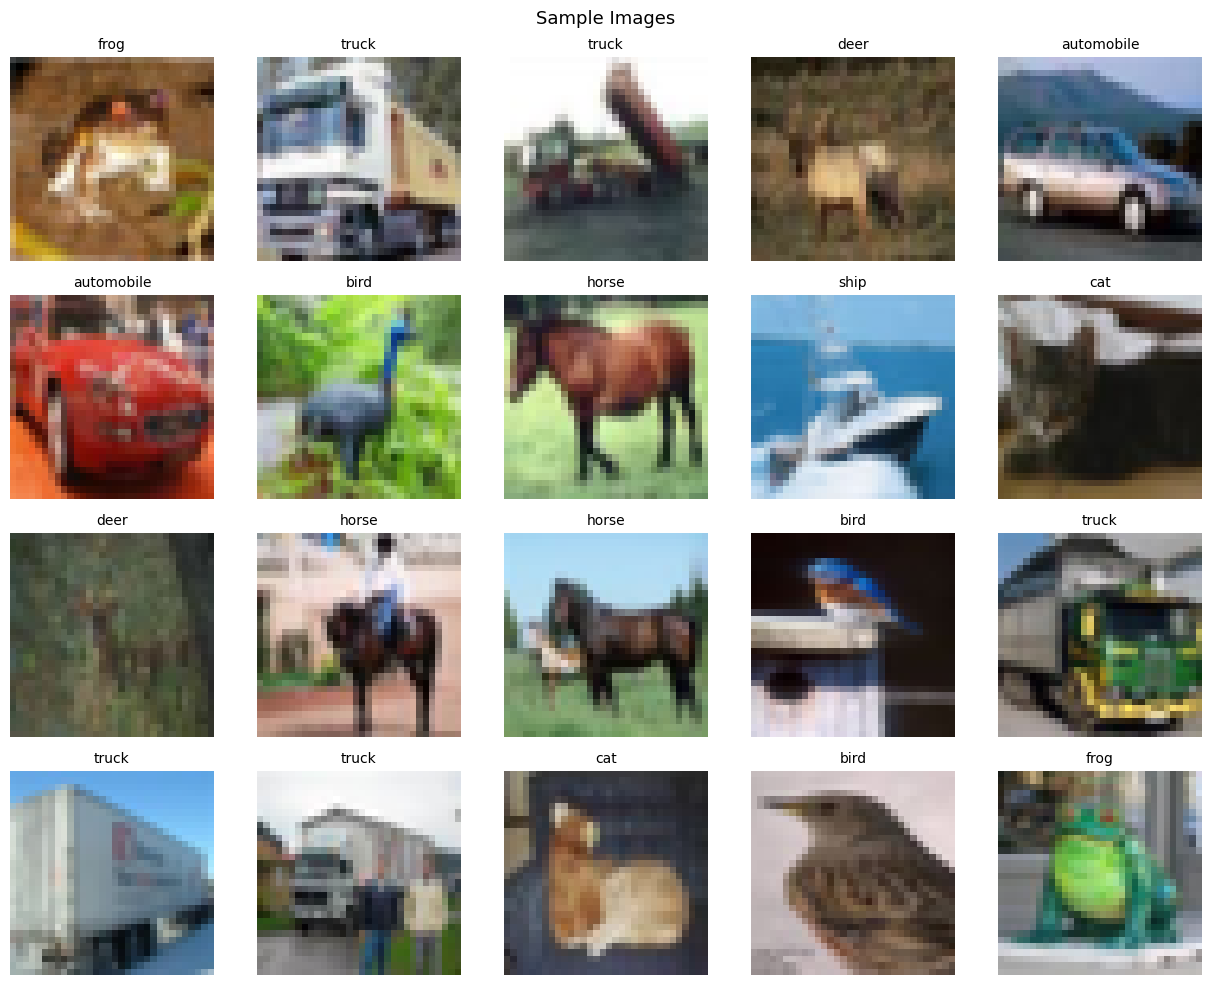

In [4]:
# Visualize some training images to verify data loaded correctly
plot_sample_images(X_train, y_train, CIFAR10_CLASSES)

In [5]:
# TODO: Build a Dense model using Sequential
# Tip: call model_dense.summary() after building to verify your architecture
# Requirements:
#   - Input(shape=(32, 32, 3))
#   - Flatten()
#   - At least 2 Dense hidden layers with activation='relu'
#   - Dropout after each hidden Dense layer
#   - Dense(10, activation='softmax') as output
# replace with your Sequential model

model_dense = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_dense.summary()  

/workspaces/06-brainiac-oscar-peng/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# TODO: Compile the model
# model_dense.compile(optimizer='adam',
#                     loss='categorical_crossentropy',
#                     metrics=['accuracy'])

model_dense.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [8]:
# TODO: Train with EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3,
#                            restore_best_weights=True)
# history_dense = model_dense.fit(X_train, y_train,
#                                 epochs=20, batch_size=128,
#                                 validation_split=0.1,
#                                 callbacks=[early_stop])
early_stop = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True)

history_dense = model_dense.fit(X_train, y_train,
                                epochs=20, batch_size=128,
                                validation_split=0.1,
                                callbacks=[early_stop])

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2013 - loss: 2.1369 - val_accuracy: 0.2996 - val_loss: 1.9533
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.2364 - loss: 2.0181 - val_accuracy: 0.3222 - val_loss: 1.9222
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2446 - loss: 1.9937 - val_accuracy: 0.3172 - val_loss: 1.9451
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.2558 - loss: 1.9763 - val_accuracy: 0.3154 - val_loss: 1.9217
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2567 - loss: 1.9636 - val_accuracy: 0.2986 - val_loss: 1.9478
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2640 - loss: 1.9530 - val_accuracy: 0.3294 - val_loss: 1.9103
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2649 - loss: 1.9432 - val_accuracy: 0.3210 - val_loss: 1.9416
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.2734 - loss: 1.9399 - val_acc

In [10]:
# TODO: Evaluate on test set
# test_loss, test_acc = model_dense.evaluate(X_test, y_test, verbose=0)
test_loss, test_acc = model_dense.evaluate(X_test, y_test, verbose=0)  # replace

# TODO: Generate predictions and confusion matrix
# y_pred = np.argmax(model_dense.predict(X_test, verbose=0), axis=1)
# y_true = np.argmax(y_test, axis=1)
# cm = confusion_matrix(y_true, y_pred)
y_pred = np.argmax(model_dense.predict(X_test, verbose=0), axis=1)  # replace
y_true = np.argmax(y_test, axis=1)  # replace
cm = confusion_matrix(y_true, y_pred)  # replace

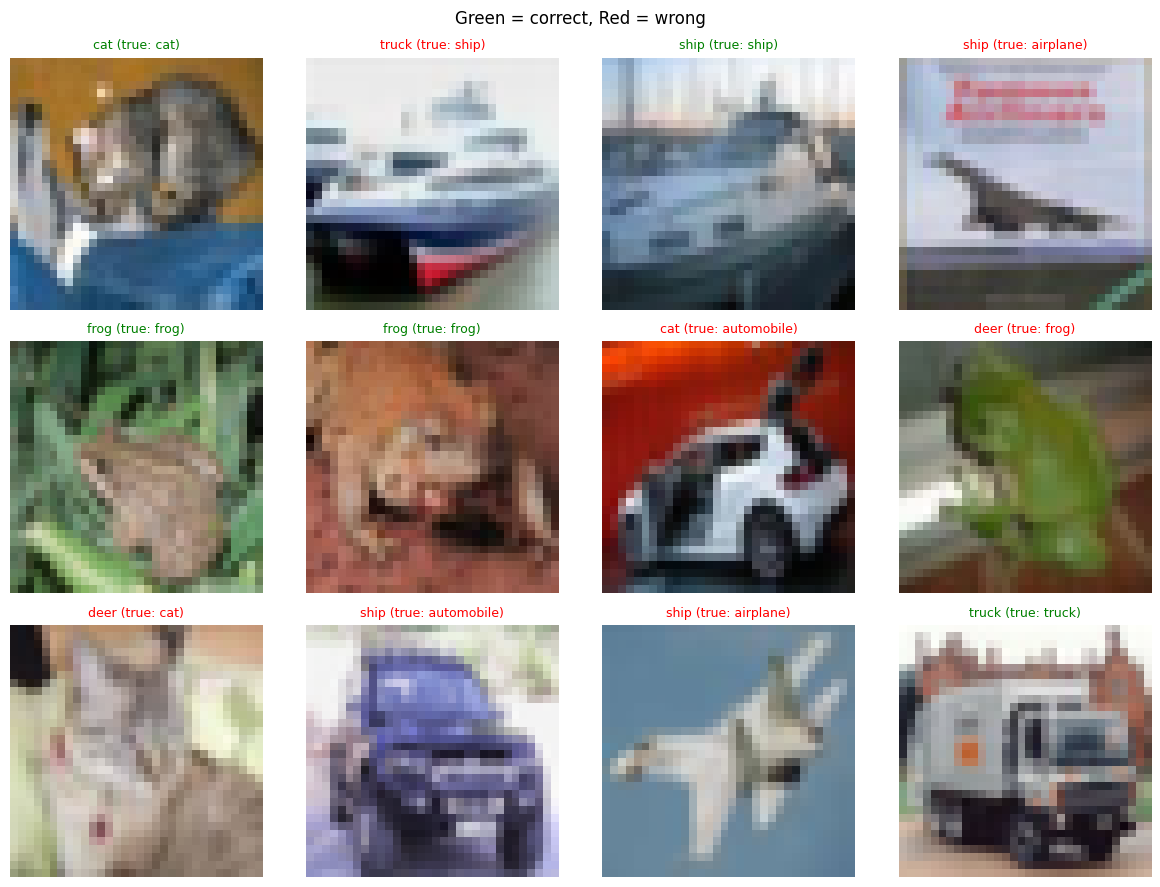

In [11]:
# Optional: visualize predictions and confusion matrix to diagnose issues
plot_predictions(X_test, y_true, y_pred, CIFAR10_CLASSES)
plot_confusion_matrix(y_true, y_pred, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part1_confusion_matrix.png"))

In [12]:
# Save results (do not modify this cell)
results = {
    "accuracy": float(test_acc),
    "confusion_matrix": cm.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Dense accuracy: {test_acc:.4f}")
print("Saved output/part1_results.json")

Dense accuracy: 0.3338
Saved output/part1_results.json


---

## Part 2: CNN on CIFAR-10

**Task:** Build a CNN to classify the same CIFAR-10 images. Compare its accuracy
to the Dense baseline from Part 1.

CNNs use convolutional filters that slide across the image, detecting local
patterns (edges, textures, shapes). This preserves spatial structure that
Dense layers discard.

**Architecture requirements:**
- At least 2 Conv2D + MaxPooling2D blocks
- Flatten, then Dense hidden layer with Dropout
- Output: Dense(10, softmax)

In [13]:
print("\nPart 2: CNN on CIFAR-10")
print("-" * 40)

# Data is already loaded from Part 1 (X_train, y_train, X_test, y_test)


Part 2: CNN on CIFAR-10
----------------------------------------


In [14]:
# TODO: Build a CNN model using Sequential
# Requirements:
#   - Input(shape=(32, 32, 3))
#   - At least 2 blocks of: Conv2D(filters, (3,3), activation='relu')
#                            + MaxPooling2D((2,2))
#   - Flatten()
#   - Dense hidden layer with ReLU + Dropout
#   - Dense(10, activation='softmax') as output
# Tip: call model_cnn.summary() after building to check layer shapes and param counts
model_cnn = Sequential([
    # Layer 1: detect simple features (edges, colors)
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2: detect more complex features (corners, textures)
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Flatten(), # Reshape 3D feature maps to 1D vector for Dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])  # replace with your Sequential model

/workspaces/06-brainiac-oscar-peng/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# TODO: Compile the model
# model_cnn.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
# TODO: Train with EarlyStopping and ModelCheckpoint
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3,
#                   restore_best_weights=True),
#     ModelCheckpoint('output/best_cnn.keras',
#                     save_best_only=True, monitor='val_accuracy'),
# ]
# history_cnn = model_cnn.fit(X_train, y_train,
#                             epochs=15, batch_size=64,
#                             validation_split=0.1,
#                             callbacks=callbacks)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3,
                  restore_best_weights=True),
    ModelCheckpoint('output/best_cnn.keras',
                    save_best_only=True, monitor='val_accuracy'),
]
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=15, batch_size=64,
                            validation_split=0.1,
                            callbacks=callbacks)

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.3970 - loss: 1.6547 - val_accuracy: 0.5380 - val_loss: 1.3031
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.5288 - loss: 1.3270 - val_accuracy: 0.5930 - val_loss: 1.1359
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.5740 - loss: 1.2136 - val_accuracy: 0.6292 - val_loss: 1.0699
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6029 - loss: 1.1342 - val_accuracy: 0.6438 - val_loss: 1.0083
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.6225 - loss: 1.0779 - val_accuracy: 0.6556 - val_loss: 0.9856
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.6402 - loss: 1.0244 - val_accuracy: 0.6682 - val_loss: 0.9612
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.6573 - loss: 0.9804 - val_accuracy: 0.6580 - val_loss: 0.9825
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6674 - loss: 0.9446 - 

In [17]:
# TODO: Plot training history
plot_training_history(history_cnn,
                      os.path.join(OUTPUT_DIR, "part2_training_history.png"))

In [18]:
# TODO: Evaluate on test set
# cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test, verbose=0)
cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test, verbose=0) # replace

# TODO: Generate predictions and confusion matrix
# y_pred_cnn = np.argmax(model_cnn.predict(X_test, verbose=0), axis=1)
# y_true_cnn = np.argmax(y_test, axis=1)
# cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
y_pred_cnn = np.argmax(model_cnn.predict(X_test, verbose=0), axis=1)
y_true_cnn = np.argmax(y_test, axis=1)
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

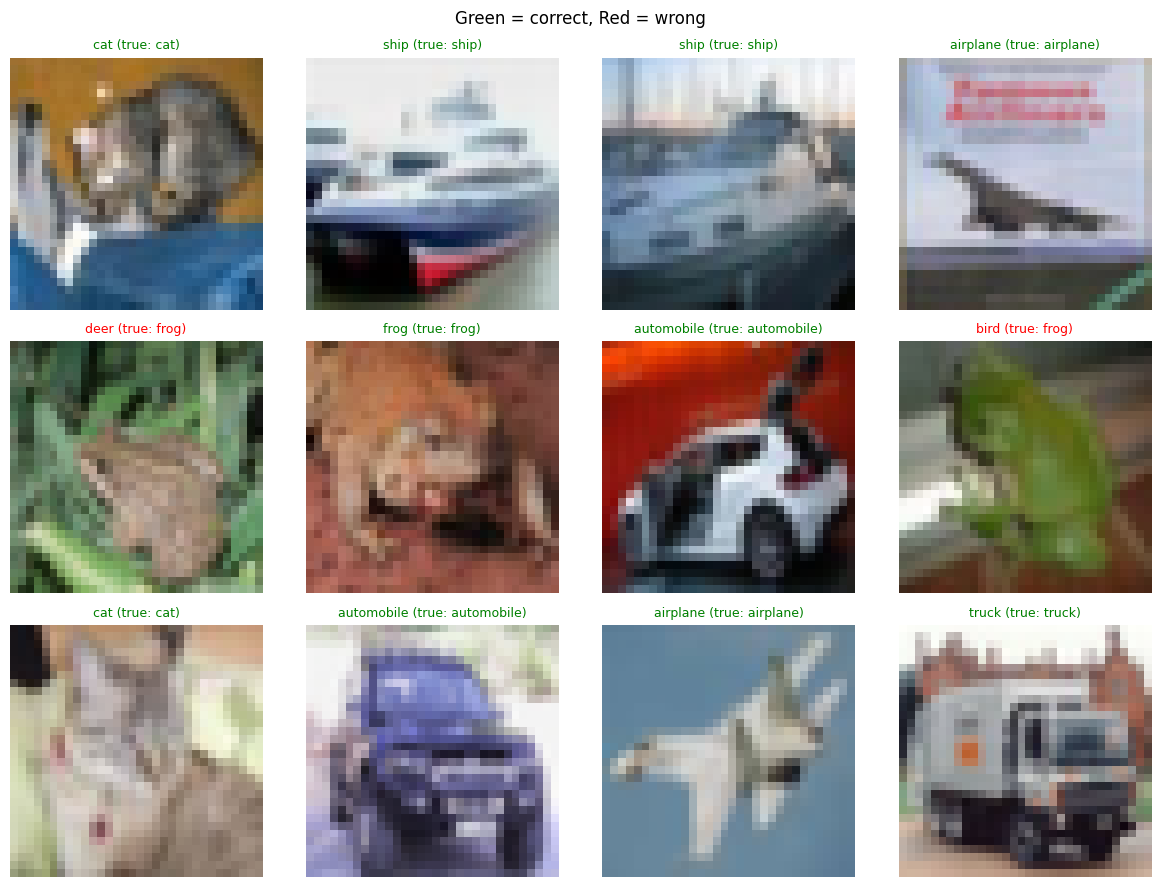

In [19]:
# Optional: visualize predictions and confusion matrix to diagnose issues
# plot_predictions(X_test, y_true_cnn, y_pred_cnn, CIFAR10_CLASSES)
# plot_confusion_matrix(y_true_cnn, y_pred_cnn, list(CIFAR10_CLASSES.values()),
#                       os.path.join(OUTPUT_DIR, "part2_confusion_matrix.png"))

plot_predictions(X_test, y_true_cnn, y_pred_cnn, CIFAR10_CLASSES)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part2_confusion_matrix.png"))

In [20]:
# Save results (do not modify this cell)
results_cnn = {
    "accuracy": float(cnn_acc),
    "confusion_matrix": cm_cnn.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part2_results.json"), "w") as f:
    json.dump(results_cnn, f, indent=2)

comparison = pd.DataFrame([
    {"model": "Dense", "accuracy": float(test_acc)},
    {"model": "CNN", "accuracy": float(cnn_acc)},
])
comparison.to_csv(os.path.join(OUTPUT_DIR, "part2_comparison.csv"), index=False)

print(f"CNN accuracy:   {cnn_acc:.4f}")
print(f"Dense accuracy: {test_acc:.4f}")
print(f"Improvement:    {cnn_acc - test_acc:+.4f}")
print("Saved output/part2_results.json and output/part2_comparison.csv")

CNN accuracy:   0.6934
Dense accuracy: 0.3338
Improvement:    +0.3596
Saved output/part2_results.json and output/part2_comparison.csv


---

## Part 3: LSTM on ECG5000

**Task:** Build an LSTM to classify heartbeat recordings.

ECG5000 contains 5,000 heartbeat recordings — each is 140 time steps of voltage
measurements, classified into 5 types (Normal, Supraventricular, Premature
Ventricular, Fusion, Unknown). This is sequential data where order matters,
making it a natural fit for recurrent networks.

**Architecture requirements:**
- LSTM layer (any reasonable number of units)
- Dropout for regularization
- Dense output with softmax (5 classes)

In [26]:
print("\nPart 3: LSTM on ECG5000")
print("-" * 40)

# Load ECG data (already shaped for RNN input)
X_train_ecg, y_train_ecg, X_test_ecg, y_test_ecg = load_ecg5000()
print(f"Train: {X_train_ecg.shape}, Test: {X_test_ecg.shape}")
print(f"Classes: {list(ECG_CLASSES.values())}")


Part 3: LSTM on ECG5000
----------------------------------------
Train: (4000, 140, 1), Test: (1000, 140, 1)
Classes: ['Normal', 'Supraventricular', 'Premature Ventricular', 'Fusion', 'Unknown']


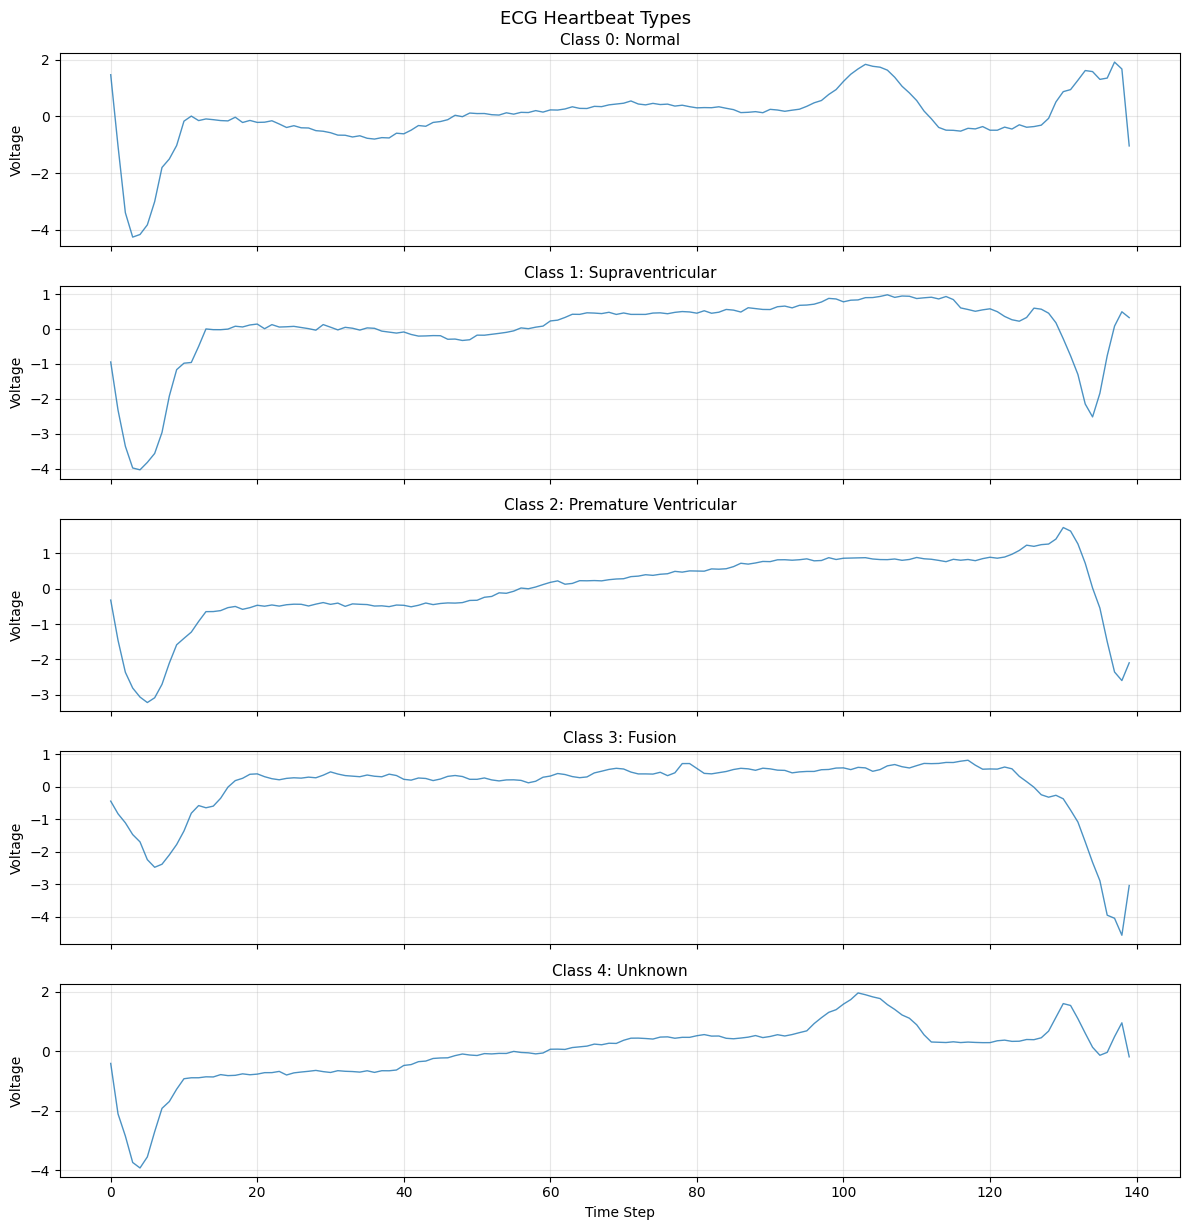

In [27]:
# Visualize ECG traces to understand the data
plot_ecg_traces(X_train_ecg, y_train_ecg, ECG_CLASSES)

In [28]:
# TODO: Build an LSTM model using Sequential
# Requirements:
#   - Input(shape=(140, 1))
#   - LSTM layer (e.g., 64 units)
#   - Dropout
#   - Dense(5, activation='softmax')
# Tip: call model_lstm.summary() after building to verify your architecture
model_lstm = Sequential([
    LSTM(64, input_shape=(140, 1)), # Classify ECG recordings: 140 time steps, 1 feature (voltage)
    Dropout(0.5), # Regularize to prevent overfitting on small dataset
    Dense(5, activation='softmax') # 5 classes of heartbeats
])  # replace with your Sequential model

In [30]:
# TODO: Compile the model
# model_lstm.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

model_lstm.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [31]:
# TODO: Train with EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=5,
#                            restore_best_weights=True)
# history_lstm = model_lstm.fit(X_train_ecg, y_train_ecg,
#                               epochs=30, batch_size=32,
#                               validation_split=0.1,
#                               callbacks=[early_stop])
early_stop = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_ecg, y_train_ecg,
                              epochs=30, batch_size=32,
                              validation_split=0.1,
                              callbacks=[early_stop])

Epoch 1/30


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8683 - loss: 0.5843 - val_accuracy: 0.8925 - val_loss: 0.3878
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9289 - loss: 0.2782 - val_accuracy: 0.9100 - val_loss: 0.3251
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9381 - loss: 0.2438 - val_accuracy: 0.9150 - val_loss: 0.2857
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9425 - loss: 0.2263 - val_accuracy: 0.9200 - val_loss: 0.2875
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9419 - loss: 0.2143 - val_accuracy: 0.9150 - val_loss: 0.2681
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9444 - loss: 0.2110 - val_accuracy: 0.9175 - val_loss: 0.2595
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9419 - loss: 0.2080 - val_accuracy: 0.9100 - val_loss: 0.2764
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9394 - loss: 0.2297 - val_accuracy: 0.920

In [32]:
# TODO: Plot training history
plot_training_history(history_lstm,
                      os.path.join(OUTPUT_DIR, "part3_training_history.png"))

In [33]:
# TODO: Evaluate on test set
# lstm_loss, lstm_acc = model_lstm.evaluate(X_test_ecg, y_test_ecg, verbose=0)
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_ecg, y_test_ecg, verbose=0)

# TODO: Generate predictions and confusion matrix
# y_pred_ecg = np.argmax(model_lstm.predict(X_test_ecg, verbose=0), axis=1)
# y_true_ecg = np.argmax(y_test_ecg, axis=1)
# cm_ecg = confusion_matrix(y_true_ecg, y_pred_ecg)
y_pred_ecg = np.argmax(model_lstm.predict(X_test_ecg, verbose=0), axis=1)
y_true_ecg = np.argmax(y_test_ecg, axis=1)
cm_ecg = confusion_matrix(y_true_ecg, y_pred_ecg)

In [34]:
# Optional: visualize confusion matrix to see which heartbeat types are confused
plot_confusion_matrix(y_true_ecg, y_pred_ecg, list(ECG_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png"))

In [35]:
# Save results (do not modify this cell)
results_ecg = {
    "accuracy": float(lstm_acc),
    "confusion_matrix": cm_ecg.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part3_results.json"), "w") as f:
    json.dump(results_ecg, f, indent=2)

print(f"LSTM accuracy: {lstm_acc:.4f}")
print("Saved output/part3_results.json")

LSTM accuracy: 0.9390
Saved output/part3_results.json


---

## Validation

In [36]:
print("\nAll parts complete!")
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")


All parts complete!
Run 'pytest .github/tests/ -v' in your terminal to check your work.
